## Работа с VK API

### Вспомогательный код

Простой клиент для VK API . Делаем паузы перед запросами, чтобы в итоге было не более 3 запросов в секунду.

In [1]:
import time
import logging
import requests
import json
import csv

logger = logging.getLogger(__name__)

PROFILE_FIELDS = ['nickname', 'screen_name', 'sex', 'bdate', 'city', 'relation', 'country', 'home_town',
                  'education', 'universities',   'schools',  'occupation'
                  'connections', 'relation', 'relatives', 
                  'interests', 'books', 'last_seen', 'counters', ]    

class JsonUtils(object):
    @staticmethod
    def json_path(json, path, default=''):
        splited = path.split('.')
        for p in splited:
            try:
                p_id = int(p)
                json = json[p_id]
            except:
                if p in json:
                    json = json[p]
                else:
                    return default
        return json

class VkError(Exception):    
    pass
    
class VkAPI(object):    
         
    def __init__(self, token=None):
        self.session = requests.Session()
        self.session.headers['Accept'] = 'application/json'
        self.session.headers['Content-Type'] = 'application/x-www-form-urlencoded'
        
        self.token = token
        self.requests_times = []
        
    def _do_api_call(self, method, params):
        self._pause_before_request()
        
        if self.token:
            params['access_token'] = self.token
        params['v'] = '5.26'
            
        param_str = '&'.join(['%s=%s' % (k, v) for k, v in params.items()])
        url = 'https://api.vk.com/method/%s?%s' % (method, param_str)
        logger.debug('API request: %s' % (method))
        
        response = self.session.get(url)
        if response.status_code is not 200:
            time.sleep(10)
            response = self.session.get(url)
            if response.status_code is not 200:
                raise VkError('Can\'t get %s, code %s' % (url, response.status_code))        
                
        json = response.json()
        if 'response' not in json:
            if 'error' in json:   
                raise VkError('Api call error:  %s' % json['error']['error_msg'])                
            else:
                raise VkError('Api call error %s - %s' % (url, json))
                        
        return json['response'] 
        
    def _pause_before_request(self):
        if len(self.requests_times) > 1:
            first = self.requests_times[0]
            diff = time.time() - first
            if diff < 1.:
                logger.info('Sleepping for %s sec' % (1. - diff))
                time.sleep(1.- diff)
            self.requests_times = self.requests_times[1:]            
        self.requests_times.append(time.time())
        
    def get_user_profile(self, user_id, fields=PROFILE_FIELDS):    
        profile = self._do_api_call('users.get', { 'user_ids' :  user_id,  'fields' : ','.join(fields)})                    
        return profile[0]           
                            
    def get_user_profiles(self, user_ids, fields=PROFILE_FIELDS):                                 
        for offset in range(0, len(user_ids) // 100 + 1):            
            start, end = offset * 100, (offset + 1) * 100 
            ids = ','.join([str(user_id) for user_id in user_ids[start:end]])        
            response = self._do_api_call('users.get', { 'user_ids' :  ids,  'fields' : ','.join(fields)})
            yield from response        
    
    def get_group_users(self, group_id, fields=PROFILE_FIELDS):
        members_count = self._do_api_call('groups.getById', 
                                          { 'group_id' :  group_id,  'fields' : 'members_count'})[0]['members_count'] 
        
        for offset in range(0, members_count // 1000 + 1):
            response = self._do_api_call('groups.getMembers', { 'group_id' :  group_id, 'offset' : offset * 1000})
            yield from response['items']      
    
    def get_friends(self, user_id, fields=[]):
        response = self._do_api_call('friends.get', { 'user_id' : user_id,   'fields' : ','.join(fields)})                    
        return response['items']
                    
    def close():
        self.session.close()        

    def get_user_network(self, user_id, depth):          
        all_profiles = dict()
        logger.info('Getting profile for id%s' % user_id)
        all_profiles[user_id] = self.get_user_profile(user_id)
        
        queue = [(user_id, depth)]       
        while len(queue) > 0:
            head_id, head_depth = queue[0]        
            logger.info('Getting friends for id%s' % head_id)   
            friends = []
            try:
                friends = self.get_friends(head_id, fields=[])    
            except VkError as e:
                pass            
            all_profiles[head_id]['friends'] = friends
            
            if head_depth > 1:            
                for friend_id in friends:                    
                    if friend_id not in all_profiles:
                        all_profiles[friend_id] = {'id' : friend_id }
                        queue.append((friend_id, head_depth - 1))
            queue.pop(0) 
        return all_profiles 
    
    @staticmethod         
    def save_friends_csv(fname, user_network):   
        with open(fname, 'w') as of:
            pairs = set()
            for k, v in user_network.items():
                k = int(k)
                for fr in v['friends']:
                    if fr in user_network:                    
                        if (k, fr) not in pairs:
                            of.write('%d %d\n' % (k, fr))
                            pairs.add((k, fr))
                        if (fr, k) not in pairs:
                            of.write('%d %d\n' % (fr, k))
                            pairs.add((fr, k))   
     
    @staticmethod                        
    def save_profiles_json(fname, user_network):   
        with open(fname, 'w', encoding='utf-8') as of:
            of.write(json.dumps(user_network)) 
            
    @staticmethod 
    def save_profiles_csv(fname, user_network):         
        fields = ['id', 'nickname', 'first_name', 'last_name', 'bdate', 'screen_name', 'sex', 
                  'city.id', 'city.title', 
                  'home_town',
                  'country.id', 'country.title', 
                  'universities.0.id', 'universities.0.name', 'universities.0.city', 'universities.0.graduation', 
                  'occupation.type', 'occupation.id', 'occupation.name', 
                  'schools.0.id', 'schools.0.name', 'schools.0.city', 'schools.0.year_graduated', 
                  ]

        with open(fname, 'wb') as of:           
            profiles_writer = csv.DictWriter(of, delimiter=',', quoting=csv.QUOTE_NONNUMERIC, fieldnames=fields)
            profiles_writer.writeheader()
            for user_profile in user_network:
                profiles_writer.writerow({ field : JsonUtils.json_path(user_profile, field).encode('utf-8') for field in fields})                     

Стандартная шапка

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

## Получение друзей пользователя и простейший анализ дружеских связей

Создаем объект, с помощью которого будем обращаться к API Вконтакте

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

api = VkAPI()

Получаем случайное целое число, оно будет идентификатором пользователя, над которым будем эксперементировать

In [4]:
user_id = 6 #np.random.randint(1, 5000)

Загружаем идентификаторы всех друзей нашего пользователя, потом списки всех друзей друзей и сохраняем результат в словаре

In [5]:
friends_ids = api.get_friends(user_id)
friends_ids_set = set(friends_ids)

user_network = { user_id : friends_ids }

for friend_id in tqdm(friends_ids):
    try:
        friend_friends_ids = api.get_friends(friend_id)
        user_network[friend_id] = [x for x in friend_friends_ids if x in friends_ids_set]
    except:
        pass

100%|██████████| 292/292 [02:26<00:00,  2.00it/s]


Загружаем профили друзей

In [6]:
friend_profiles = list(api.get_user_profiles(friends_ids))

friend_profiles содержит список объектов, которые полностью повторяют формат json-ответов из VK API. Например, чтобы получить город первого друга, нужно запустить что-то вроде:

In [7]:
print(friend_profiles[0]['city']['title'])

Moscow


In [8]:
friend_profiles[0].keys()

dict_keys(['id', 'first_name', 'last_name', 'sex', 'nickname', 'screen_name', 'bdate', 'city', 'country', 'last_seen'])

Теперь попробуем воспользоваться Pandas, для этого нам нужно превратить иерархические даные из профиля к плоскому, табличному виду. В данным момент нам интересны только поля из списка *fields*, в котором *schools.0.year_graduated* означает: "взять год окончания первой (хронологически последней) школы из спика". Далее получаем: 

In [9]:
fields = ['first_name', 'last_name', 'bdate','sex', 
         'city.title', 
         'universities.0.name', 
         'schools.0.name', 'schools.0.year_graduated']               

def transform_user_profile(user_profile):
    return [JsonUtils.json_path(user_profile, field, default=None) for field in fields]
            
index = [int(fp['id']) for fp in friend_profiles]
data = [transform_user_profile(fp) for fp in friend_profiles]
df = pd.DataFrame(index=index, data=data, columns=fields)

df.head(30)

,first_name,last_name,bdate,sex,city.title,universities.0.name,schools.0.name,schools.0.year_graduated
5,Ilya,Perekopsky,18.11,2,Moscow,None,None,NaN
7,Alexey,Kobylyansky,None,2,London,None,None,NaN
10,Alexander,Kuznetsov,None,2,Saint Petersburg,None,None,NaN
14,Andrey,Gorodetsky,29.6.1982,2,London,СПбГУ,Вторая Санкт-Петербургская Гимназия,1999.0
17,Alexander,Bespalov,21.10.1982,2,Saint Petersburg,None,None,NaN
21,Mikhail,Ravdonikas,23.7.1985,2,Saint Petersburg,СПбГУ,None,NaN
23,Andrey,Stolbovsky,14.11,2,Saint Petersburg,None,None,NaN
34,Tatyana,Plutalova,2.6,1,Saint Petersburg,None,None,NaN
42,Sergey,Markin,20.4,2,Saint Petersburg,None,None,NaN
45,Sergey,Vinogradov,28.1,2,Saint Petersburg,None,None,NaN


Теперь создадим новую колонку *age*, куда запишем возраст пользователя (если он, конечно, задан)

In [10]:
import datetime as dt

year = dt.datetime.now().year

def map_age(x):
    if x is not None:
        splited = x.split('.')
        if len(splited) == 3:
            return year - int(splited[2])
    return None

df['age'] = df.loc[:, 'bdate'].map(map_age)

Выведем данные друзей, у которых указан возраст

In [11]:
has_age = pd.notnull(df['age'])
df.loc[has_age, ['first_name', 'last_name', 'age']][:10]

,first_name,last_name,age
14,Andrey,Gorodetsky,37.0
17,Alexander,Bespalov,37.0
21,Mikhail,Ravdonikas,34.0
46,Andrey,Lesokhin,35.0
59,Anastasia,Zheludkova,34.0
169,Olga,Chistokletova,32.0
234,Yulia,Gleym,34.0
243,Ekaterina,Skobeyko,32.0
632,Yana,Kalney,33.0
1634,Sergey,Martynov,36.0


Построим гистограмму

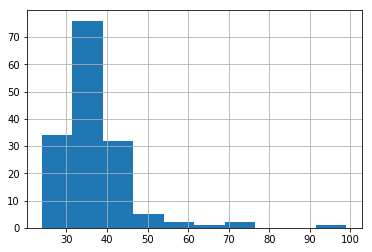

In [12]:
df['age'].hist()

Города проживания друзей

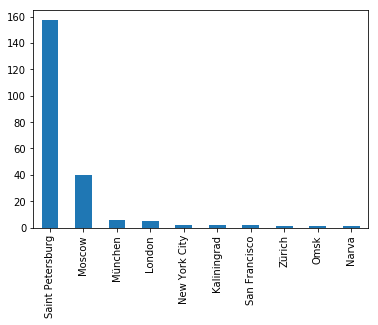

In [13]:
df['city.title'] = df['city.title'].astype('category')
df['city.title'].value_counts()[:10].plot(kind='bar')

Построим граф дружеских связей друзей пользователя

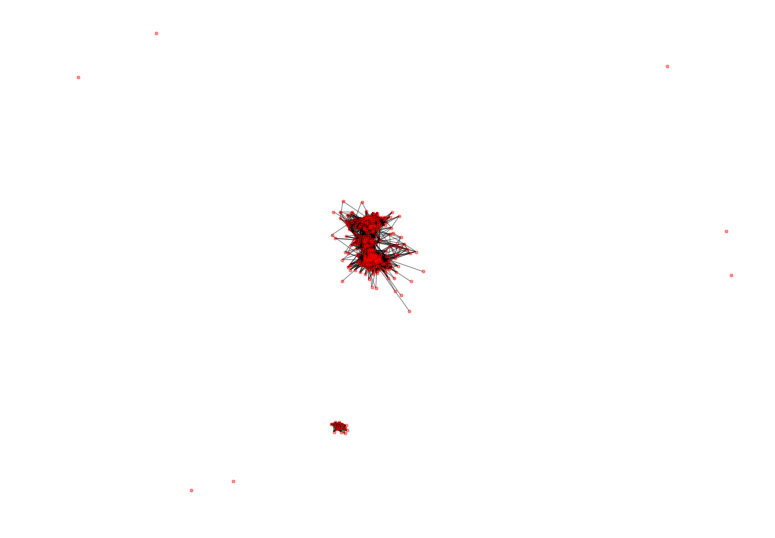

In [14]:
import networkx as nx

graph = nx.Graph()
for user, friends in user_network.items():    
    for friend in friends:
        graph.add_edge(user, friend)
        
graph.remove_node(user_id)        
plt.figure(figsize=(10, 7))
nx.draw_spring(graph, node_size=8, alpha=0.4)

Теперь кластеризуем этот граф и создадим новую колонку в DataFrame с идентификатором кластера

In [15]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

communities = greedy_modularity_communities(graph)
user_to_community = {user_id : community_id for (community_id, community_users) in enumerate(communities) 
                                            for user_id in community_users}
df['community'] = df.index.map(lambda x : user_to_community[x] if x in user_to_community else None)
df.loc[has_age, ['first_name', 'last_name', 'age', 'universities.0.name', 'schools.0.name', 'community']][:10]

,first_name,last_name,age,universities.0.name,schools.0.name,community
14,Andrey,Gorodetsky,37.0,СПбГУ,Вторая Санкт-Петербургская Гимназия,0
17,Alexander,Bespalov,37.0,None,None,0
21,Mikhail,Ravdonikas,34.0,СПбГУ,None,0
46,Andrey,Lesokhin,35.0,None,None,0
59,Anastasia,Zheludkova,34.0,None,None,0
169,Olga,Chistokletova,32.0,None,None,0
234,Yulia,Gleym,34.0,None,None,0
243,Ekaterina,Skobeyko,32.0,None,None,0
632,Yana,Kalney,33.0,None,None,0
1634,Sergey,Martynov,36.0,МГУ,Курчатовская школа (Шк. №1189 им. И. В. Курчат...,0


Визуально проверим адекватность кластеризации, раскрасив граф в зависимости от кластера

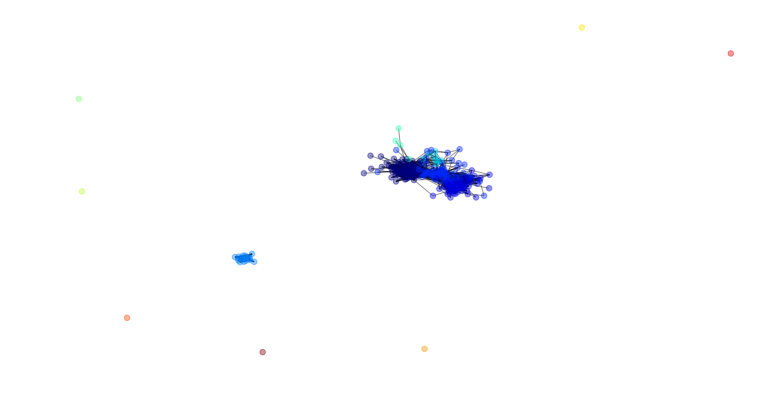

In [16]:
communities_list = [user_to_community[node] for node in graph.nodes()]
plt.figure(figsize=(10, 5))
nx.draw_spring(graph, cmap=plt.get_cmap('jet'), node_color=communities_list, node_size=30, alpha=0.4)

Тепер пометим одним цветом людей из одного университета

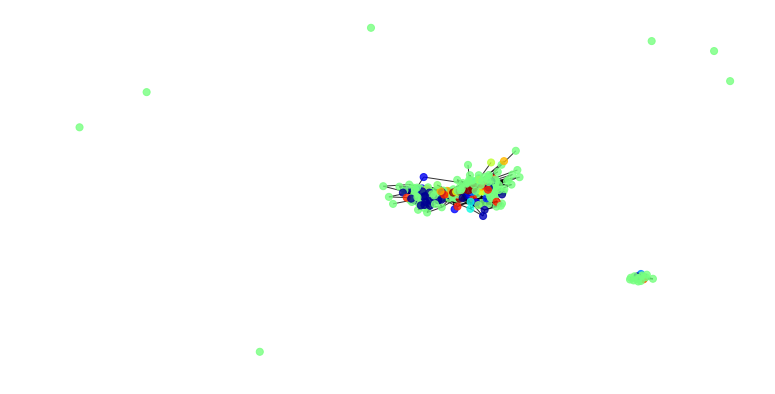

In [17]:
communities_list = [hash(df.loc[node, ['universities.0.name']][0]) for node in graph.nodes()]
plt.figure(figsize=(10, 5))
nx.draw_spring(graph, cmap=plt.get_cmap('jet'), node_color=communities_list, node_size=50, alpha=0.8)

## Работа с группами

Возьмем две группы: <br/>
https://vk.com/zclassic - любители классической музыки <br/>
https://vk.com/club7057 - любители русского рэпа

Посмотрим чем отличаются подписчики этих групп. Для начала по возрасту

Закачиваем списки групп

In [18]:
classic_lovers_ids = [x for x in tqdm(api.get_group_users(13333245))]
rap_lovers_ids =  [x for x in tqdm(api.get_group_users(7057))]

116921it [00:58, 2005.86it/s]
199122it [01:40, 1972.07it/s]


Закачиваем профили первых 10000 пользователей, нас интересует только даты рождения

In [19]:
classic_lovers = [x for x in tqdm(api.get_user_profiles(classic_lovers_ids[:10000], fields=['bdate']))]
rap_lovers = [x for x in tqdm(api.get_user_profiles(rap_lovers_ids[:10000], fields=['bdate']))]

10000it [00:50, 197.97it/s]
10000it [00:50, 197.50it/s]


Преобразуем данные в два DataFrame, в которых будет по два столбца - возраст и месяц рождения.

In [20]:
def map_month(x):    
    if x is not None:
        splited = x.split('.')        
        if len(splited) > 1:
            return int(splited[1])        
    return None
    
def make_data_frame(data):
    data = [JsonUtils.json_path(x, 'bdate') for x in data]
    data = [(map_age(x), map_month(x)) for x in data if x != None]
    data = [(age, month) for age, month in data if (age != None) and (month != None)]    
    
    data_df = pd.DataFrame(data=data, columns=['age', 'month'])
    data_df['month'] = data_df['month'].astype('category')
    return data_df
    
    
df_c = make_data_frame(classic_lovers)
df_r = make_data_frame(rap_lovers)

Любители рэпа ожидаемо моложе:

In [21]:
df_c['age'].mean(), df_r['age'].mean()

(33.84960998439938, 32.03866481223922)

Нарисуем гистограммы. Пожилые пользователи VK явно предпочитают классическую музыку: 

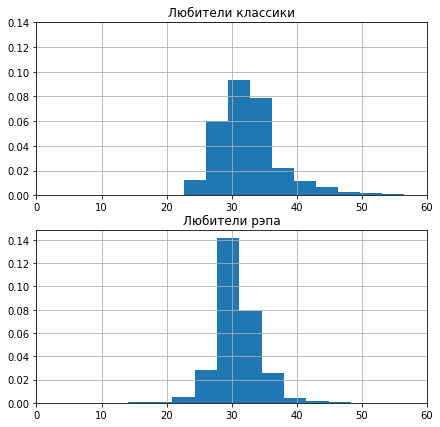

In [22]:
fig, ax = plt.subplots(2,1, figsize=(7,7))

df_c['age'].hist(ax=ax[0], normed=True, bins=30)
df_r['age'].hist(ax=ax[1], normed=True, bins=30)

ax[0].set_title('Любители классики')
ax[1].set_title('Любители рэпа')

ax[0].set_xlim((0, 60))
ax[1].set_xlim((0, 60))
ax[0].set_yticks(np.arange(0., 0.15, step=0.02))
ax[1].set_yticks(np.arange(0., 0.15, step=0.02))

(0, 60)

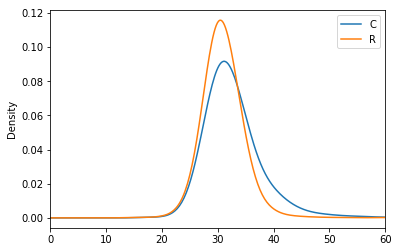

In [23]:
df_c['age'].plot(kind='kde')
df_r['age'].plot(kind='kde')
plt.legend(['C', 'R'])
plt.xlim((0, 60))

Может быть астрология работает, и любители русского рэпа родились в каком-то определенном месяце?

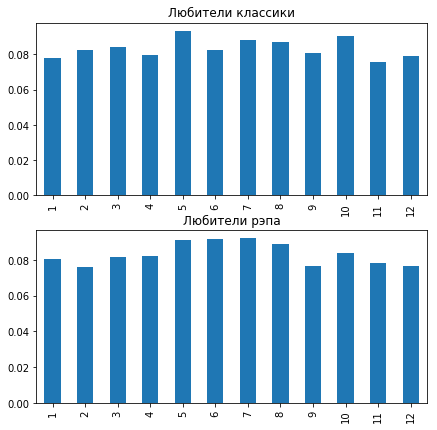

In [24]:
fig, ax = plt.subplots(2,1, figsize=(7,7))
ax[0].set_title('Любители классики')
ax[1].set_title('Любители рэпа')

df_c['month'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax[0])
df_r['month'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax[1])

Нет, ничего определенного без статистических тестов сказать нелья.

Загрузим паблик для любителей Санкт-Петербурга (https://vk.com/public45361937), и посмотрим на города проживания подписчиков

In [25]:
spb_group_ids = [x for x in tqdm(api.get_group_users(45361937))]

115322it [00:58, 1982.97it/s]


Нас интересует город проживания и родной город

In [26]:
spb_group = [x for x in tqdm(api.get_user_profiles(spb_group_ids[:20000], fields=['bdate', 'city', 'home_town']))]

20000it [01:40, 199.41it/s]


Получаем DataFrame. Увы, в *home_town* полная помойка

In [27]:
data = [(JsonUtils.json_path(x, 'city.title', default=None), 
         JsonUtils.json_path(x, 'home_town', default=None)) for x in spb_group]

In [28]:
df_spb = pd.DataFrame(data=data, columns = ['city', 'home_city'])
df_spb['city'] = df_spb['city'].astype('category')
df_spb[:10]

,city,home_city
0,Saint Petersburg,None
1,Saint Petersburg,None
2,Saint Petersburg,None
3,Saint Petersburg,None
4,Saint Petersburg,None
5,NaN,None
6,Saint Petersburg,None
7,Saint Petersburg,None
8,Saint Petersburg,None
9,Saint Petersburg,None


Можно попробовать хоть как-то привести это дело к порядку

In [29]:
has_home_city = df_spb['home_city'].map(lambda x: x is not None and len(x) > 1)
df_spb['home_city'] = df_spb.loc[has_home_city, 'home_city'].map(lambda x: x[0].upper() + x[1:])
df_spb.loc[has_home_city, :][:10]

,city,home_city
19,Saint Petersburg,Санкт-Петербург
24,Saint Petersburg,МайамиБург
36,Saratov,Нижнекамск
39,Saint Petersburg,Ленинград
41,Saint Petersburg,Ленинград
44,Moscow,Санкт-Петербург
48,Saint Petersburg,Санкт-Петербург
54,Saint Petersburg,Санкт-Петербург
60,Saint Petersburg,Санкд-Петербург
63,Saint Petersburg,Санкт-Петербург


Наконец посмотрим откуда подписчики

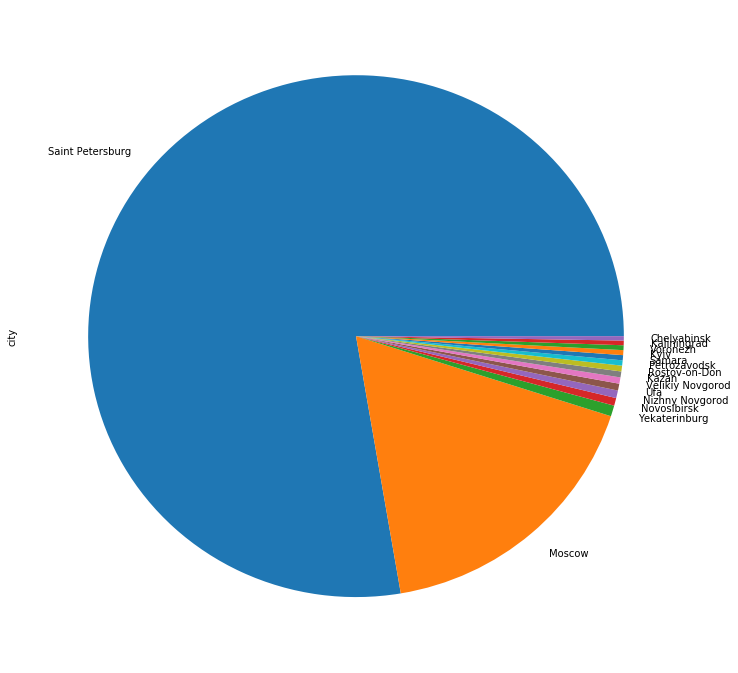

In [30]:
plt.figure(figsize=(12, 12))
df_spb['city'].value_counts(normalize=False, sort=True)[:15].plot(kind='pie')